In [1]:
!pip3 install pygad
import numpy as np
from integer_rref import i4mat_rref
# from sympy import Matrix

import pygad
import matplotlib.pyplot as plt
from cytools import Polytope
from cytools.triangulation import Triangulation
from cytools.utils import find_new_affinely_independent_points

from cytools import read_polytopes, fetch_polytopes


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

Info: A more recent version of CYTools is available: v1.0.4 -> v1.0.11.
We recommend upgrading before continuing.
On Linux and macOS you can update CYTools by running 'cytools --update'
and on Windows you can do this by running the updater tool.



In [2]:
p = Polytope([[ 0,  0,  0],
   [-1, -1,  0],
   [-1,  1,  0],
   [ 2, -1,  0],
   [ 0,  0, -1],
   [ 0,  0,  1],
   [-1,  0,  0],
   [ 0, -1,  0],
   [ 1, -1,  0]])


# p = Polytope([
#     [-1, 6, 2, 3],
#     [0, -1, 2, 3],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1],
#     [1, 6, 2, 3]
# ])

# p = Polytope([
#     [-1, 4, 2, 3],
#     [0, -1, 1, 2],
#     [0, -1, 2, 3],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1],
#     [0, 0, 2, 3],
#     [0, 2, 0, 1],
#     [1, 4, 2, 3]
# ])

# p = Polytope([[ 1,  0,  0,  0],
#        [ 0,  1,  0,  0],
#        [ 2,  4,  5,  0],
#        [ 3,  3,  0,  5],
#        [-6, -8, -5, -5]])

# p = Polytope([
#     [1,0,0,0],
#     [0,1,0,0],
#     [0,0,1,0],
#     [0,0,0,1],
#     [-1,-1,0,0],
#     [-1,-1,-1,-1],
# ])

# p = Polytope(np.asarray([[ 1,-2, 2, 0, 0, 1],
# [ 0, 0, 1, 0,-1, 0],
# [ 0,-1, 1, 1,-1, 0],
# [-3, 2,-5, 2, 1,-1],
# [-3, 5,-2,-1, 0,-3]]).T)

# p = Polytope(np.asarray([[1,  0,   0 , 21, -63],
# [0,   1,   0,  28, -56],
# [0,   0 ,  1,  36, -48],
# [0,   0 ,  0,  42, -42]]).T)

# p = Polytope()

p = Polytope([
    [-2, -1, -1],
    [-1, 1, 0],
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]).dual()

pts = p.points()[1:]

In [3]:
p.chi(lattice="N")

24

In [4]:
# p.triangulate().simplices()

In [5]:
# p.find_2d_reflexive_subpolytopes()

In [6]:
def get_indices(p, subp):
    return [np.where(np.all(v == p, axis=1))[0][0] for v in subp]

def boundary(simplices):
    dsimplices = []
    for s in simplices:
        for i in range(1, len(s)):
            dsimplices.append(
                np.append(s[:i], s[(i+1):]))

    dsimplices = np.asarray(dsimplices)
    return dsimplices

def restrict(dsimplices, subp_vertices):
    sub_simplices = np.where(np.all(np.isin(dsimplices, subp_vertices), axis=1))[0]
    sub_simplices = dsimplices[sub_simplices]

    local_sub_simplices = []
    for s in sub_simplices:
        local_s = []
        for v in s:
            local_s.append(np.where(subp_vertices == v)[0][0])
        local_sub_simplices.append(local_s)
    return np.unique(local_sub_simplices, axis=0)

def project(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return np.delete(local_vertices, idx, axis=1)

In [7]:
def reduce_polytope(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return Polytope(np.delete(local_vertices, idx, axis=1))

In [8]:
# solution = ga_instance.population[0]
# pts_sol = solution[:fibration_dimension]

# vertices_basis = []
# for p in pts_sol:
#     vertices_basis.append(pts[p])

# np.asarray(vertices_basis)

In [9]:

solutions = []


def compose(x, *args):
    out = x
    for f in args:
        out = f(out)
    return out


fibration_dimension = 2

gene_size = fibration_dimension + pts.shape[0]


def fitness_func(ga_instance, solution, solution_idx):
    pts_sol = solution[:fibration_dimension]
    # mask = (pts_sol > 0)
    # vertices_basis = pts[mask]
    vertices_basis = []
    for pt_id in pts_sol:
        vertices_basis.append(pts[pt_id])

    vertices_basis = np.asarray(vertices_basis)
        
    error = 0
    if vertices_basis.size == 0:
        return -1000

    vertices = []
    for pt_val in pts:
        if np.linalg.matrix_rank(np.append(vertices_basis, [pt_val], axis=0)) == fibration_dimension:
            vertices.append(pt_val)
    
    vertices = np.asarray(vertices)
    
    error += (np.linalg.matrix_rank(vertices) - fibration_dimension)**2
    p_reduced = reduce_polytope(vertices)

    error += (1 - p_reduced.is_reflexive())**2
    error += (fibration_dimension - p_reduced.dimension())**2

    # return -error
    # Construct a triangulation 
    heights_sol = 2*(solution[fibration_dimension:]/pts.shape[0] - .5)
    heights = [-1e3] + [pt.dot(pt) + heights_sol[i] for i, pt in enumerate(pts)]

    t = p.triangulate(heights = heights)
    error += (1-t.is_star())**2 + (1-t.is_fine())**2 + (1-t.is_regular())**2

    if error == 0:
        # Restrict triangulation
        subsimplices = restrict(
            dsimplices = compose(t.simplices(), *([boundary]*(p.dimension() - fibration_dimension))), #boundary(t.simplices()),
            subp_vertices = get_indices(
                p.points(), Polytope(vertices).points()))

        try:
            tsub = Triangulation(
                triang_pts = project(Polytope(vertices).points()),
                simplices = subsimplices)
        except Exception as e:
            # print(subsimplices)
            return -1000

        # Check that every vertex is used
        used_indices = set.union(*[set(s) for s in tsub.simplices()])
        is_fine = all(v in used_indices for v in p_reduced._triang_pt_inds(None))
        # triang_pts = tsub.points()[p_reduced._triang_pt_inds(None),:]
        # is_fine = len(set.union(*[set(s) for s in tsub.simplices()])) == len(triang_pts)
        error += (1-tsub.is_star())**2 + (1-is_fine)**2 + (1-tsub.is_regular())**2
    else:
        error += 1000
    if error <= 0:
        solutions.append((vertices, t, tsub))
    return -error

In [10]:
# Initialize GA

ga_instance = pygad.GA(
    fitness_func=fitness_func,
    num_genes=gene_size,
    save_best_solutions=False,

    num_generations=500,
    num_parents_mating=10,
    sol_per_pop=20,

    init_range_low=0,
    init_range_high=pts.shape[0],
    gene_space = {'low': 0, 'high': pts.shape[0]},
    gene_type=int,

    parent_selection_type="rws",
    keep_parents=-1,
    stop_criteria="reach_0",
    crossover_type="two_points",
    mutation_type="random",
    keep_elitism=10,
    mutation_percent_genes=20)

In [11]:
ga_instance.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


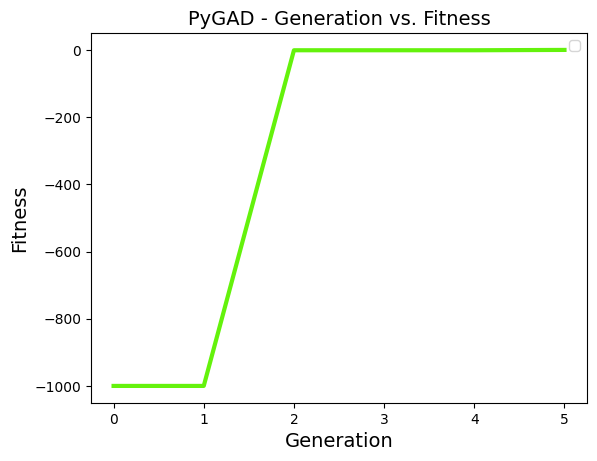

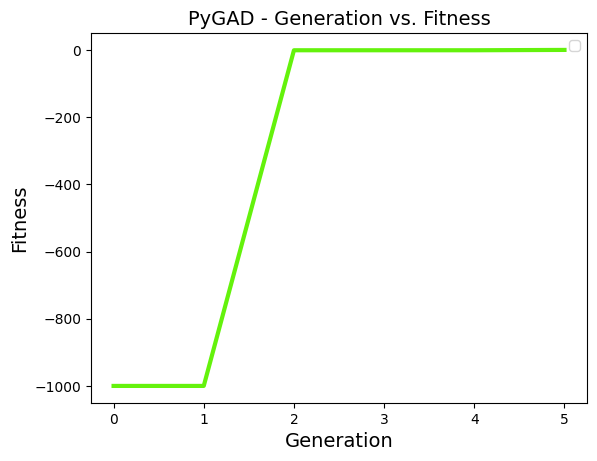

In [12]:
ga_instance.plot_fitness()

In [15]:
_,_,tsub = solutions[0]

In [16]:
Polytope(solutions[0][0]).triangulate().simplices()

array([[0, 4, 5],
       [0, 4, 6],
       [0, 5, 7],
       [0, 6, 8],
       [0, 7, 9],
       [0, 8, 9],
       [1, 4, 6],
       [2, 5, 7],
       [3, 8, 9]])

In [16]:
solutions[0][2].simplices()

array([[0, 1, 2],
       [0, 1, 3],
       [0, 2, 4],
       [0, 3, 4]])

In [17]:
p.points()

array([[ 0,  0,  0],
       [-1, -1, -1],
       [-1, -1,  4],
       [-1,  4, -1],
       [ 0, -1, -1],
       [ 0, -1,  2],
       [ 1,  0, -1],
       [-1, -1,  0],
       [-1, -1,  1],
       [-1, -1,  2],
       [-1, -1,  3],
       [-1,  0, -1],
       [-1,  0,  3],
       [-1,  1, -1],
       [-1,  1,  2],
       [-1,  2, -1],
       [-1,  2,  1],
       [-1,  3, -1],
       [-1,  3,  0],
       [ 0, -1,  0],
       [ 0, -1,  1],
       [ 0,  2, -1],
       [-1,  0,  0],
       [-1,  0,  1],
       [-1,  0,  2],
       [-1,  1,  0],
       [-1,  1,  1],
       [-1,  2,  0],
       [ 0,  0, -1],
       [ 0,  0,  1],
       [ 0,  1, -1],
       [ 0,  1,  0]])

In [18]:
solutions

[(array([[-1, -1,  0],
         [-1,  1,  0],
         [ 2, -1,  0],
         [-1,  0,  0],
         [ 0, -1,  0],
         [ 1, -1,  0]]),
  A fine, regular, star triangulation of a 3-dimensional point configuration with 9 points in ZZ^3,
  A fine, regular, star triangulation of a 2-dimensional point configuration with 7 points in ZZ^2),
 (array([[-1, -1,  0],
         [-1,  1,  0],
         [ 2, -1,  0],
         [-1,  0,  0],
         [ 0, -1,  0],
         [ 1, -1,  0]]),
  A fine, regular, star triangulation of a 3-dimensional point configuration with 9 points in ZZ^3,
  A fine, regular, star triangulation of a 2-dimensional point configuration with 7 points in ZZ^2),
 (array([[-1,  1,  0],
         [ 0,  0, -1],
         [ 0,  0,  1],
         [ 1, -1,  0]]),
  A fine, regular, star triangulation of a 3-dimensional point configuration with 9 points in ZZ^3,
  A fine, regular, star triangulation of a 2-dimensional point configuration with 5 points in ZZ^2)]

In [17]:
ga_instance.best_solution()

(array([4, 1, 7, 6, 0, 0, 6, 5, 2, 1]), 0, 0)

In [105]:
sol = solutions[0]
print(sol)

(array([[-2,  0, -1,  2,  5],
       [ 0,  0,  1,  2, -1],
       [ 1,  0,  0, -2, -3],
       [ 1,  0,  0, -2, -1]]), A fine, regular, star triangulation of a 5-dimensional point configuration with 11 points in ZZ^5, A fine, regular, star triangulation of a 3-dimensional point configuration with 7 points in ZZ^3)


In [106]:
reduce_polytope(sol[0]).points()

array([[ 0,  0,  0],
       [-2, -1,  5],
       [ 0,  1, -1],
       [ 1,  0, -3],
       [ 1,  0, -1],
       [-1,  0,  2],
       [ 1,  0, -2]])

In [107]:
reduce_polytope(sol[0]).chi(lattice='N')

24

Text(0.5, 0, '$z$')

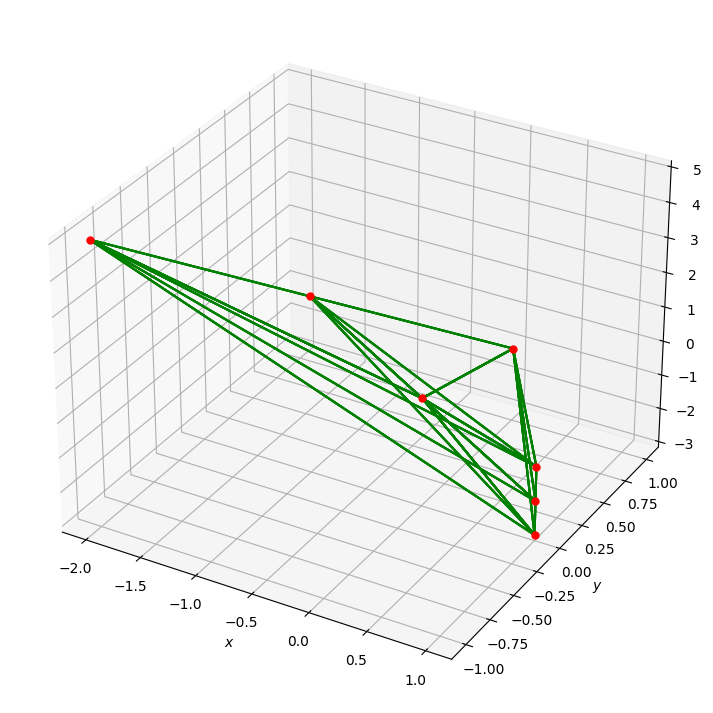

In [108]:
# Plot the facets
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')


def plot(simplices, p, params = None):
    for i, simplex in enumerate(simplices):
        for j in range(len(simplex)):
            for k in range(len(simplex)):
#                 if j == k: continue
                facet_j = lambda j: p[simplex[j % len(simplex)]]

                if params is None:
                    params = {
                        'c': 'k',
                        'linewidth': '5'}

                ax.plot(
                    [facet_j(j)[0], facet_j(j+k)[0]],
                    [facet_j(j)[1], facet_j(j+k)[1]],
                    [facet_j(j)[2], facet_j(j+k)[2]], **params)
        print("")


# plot(simplices, p)

(v, t, t_restriction) = solutions[0]
v = reduce_polytope(v).points()

# plot(t.simplices(), p.points())
# ax.plot(p.points()[:,0], p.points()[:,1], p.points()[:,2], 'bo')

plot(t_restriction.simplices(), v, params = {'c': 'g'})
ax.plot(v[:,0], v[:,1], v[:,2], 'ro', markersize=5)
# ax.plot(subp_2[:,0], subp_2[:,1], subp_2[:,2], 'ro', markersize=5)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

In [109]:
t_restriction._triang_pts

array([[ 0,  0,  0],
       [-2, -1,  5],
       [ 0,  1, -1],
       [ 1,  0, -3],
       [ 1,  0, -1],
       [-1,  0,  2],
       [ 1,  0, -2]])

In [110]:
t_restriction.points()

array([[ 0,  0,  0],
       [-2, -1,  5],
       [ 0,  1, -1],
       [ 1,  0, -3],
       [ 1,  0, -1],
       [-1,  0,  2],
       [ 1,  0, -2]])

In [97]:
t_restriction.simplices()

array([[0, 1, 2, 3],
       [0, 1, 2, 5],
       [0, 1, 3, 4],
       [0, 1, 4, 5],
       [0, 2, 3, 5],
       [0, 3, 4, 5]])

In [84]:
reduce_polytope(v).triangulate().simplices()

array([[0, 1, 2, 3],
       [0, 1, 2, 5],
       [0, 1, 3, 4],
       [0, 1, 4, 5],
       [0, 2, 3, 5],
       [0, 3, 4, 5]])

In [59]:
reduce_polytope(v).chi(lattice='N')

24

In [47]:
t_restriction.simplices()

array([[0, 1, 3, 5],
       [0, 1, 3, 6],
       [0, 1, 4, 5],
       [0, 1, 4, 6],
       [0, 2, 3, 5],
       [0, 2, 3, 6],
       [0, 2, 4, 5],
       [0, 2, 4, 6]])

In [44]:
solution = ga_instance.best_solution()[0]


pts_sol = solution[:gene_size//2]
mask = (pts_sol > 0)
vertices = pts[mask]

error = 0

error += (np.linalg.matrix_rank(vertices) - fibration_dimension)**2
p_reduced = reduce_polytope(vertices)

error += (1 - p_reduced.is_reflexive())**2
error += (fibration_dimension - p_reduced.dimension())**2

# Construct a triangulation 
heights_sol = solution[gene_size//2:]
heights = [-1e3] + [pt.dot(pt) + heights_sol[i] for i, pt in enumerate(pts)]

t = p.triangulate(heights = heights)
# error += (1-t.is_star())**2 + (1-t.is_fine())**2 + (1-t.is_regular())**2



if error == 0:
    # Restrict triangulation
    subsimplices = restrict(
        dsimplices = compose(t.simplices(), *([boundary]*(p.dimension() - fibration_dimension))), #boundary(t.simplices()),
        subp_vertices = get_indices(
            p.points(), Polytope(vertices).points()))

    try:
        tsub = Triangulation(
            triang_pts = project(Polytope(vertices).points()),
            simplices = subsimplices)
    except Exception as e:
        print(e)
        # print(subsimplices)
        error += 1000

    # Check that every vertex is used
    used_indices = set.union(*[set(s) for s in tsub.simplices()])
    is_fine = all(v in used_indices for v in p_reduced._triang_pt_inds(None))
    # triang_pts = tsub.points()[p_reduced._triang_pt_inds(None),:]
    # is_fine = len(set.union(*[set(s) for s in tsub.simplices()])) == len(triang_pts)
    error += (1-tsub.is_star())**2 + (1-is_fine)**2 + (1-tsub.is_regular())**2
else:
    error += 1000
if error <= 0:
    solutions.append((vertices, t, tsub))


In [47]:
tsub.simplices()

array([[0, 1, 2]])